# Dimensionality Reduction

## PCA

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [6]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

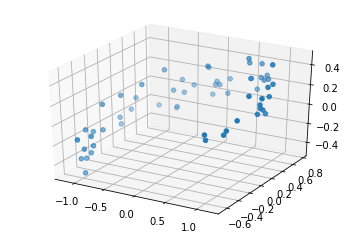

In [19]:
ax = plt.axes(projection="3d")
ax.scatter3D(X[:, 0], X[:, 1], X[:, 2]); # , c=X[:, 2], cmap=plt.cm.Blues);

Singular Value Decomposition (SVD):

$\mathbf{X} = \mathbf{U}\cdot\Sigma\cdot\mathbf{V}^T$

- $\mathbf{V}$ contains all components of $\mathbf{X}$

$\mathbf{V} = \left(\begin{array}{ccc}
\mid & \mid & \phantom{\ldots} & \mid\\
\mathbf{c_1} & \mathbf{c_2} & \ldots & \mathbf{c_n}\\
\mid & \mid & \phantom{\ldots} & \mid\\
\end{array}\right)$

In [23]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]
print("c1: {}\nc2: {}".format(c1, c2))

c1: [0.93636116 0.29854881 0.18465208]
c2: [-0.34027485  0.90119108  0.2684542 ]


**Projection $\mathbf{X}$ to d-dimensional space**

$\mathbf{X}_{d\text{-projection}}=\mathbf{X}\cdot\mathbf{W}_d$

In [24]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)
print("Shape of X: ", X.shape)
print("Shape of X2D: ", X2D.shape)

Shape of X:  (60, 3)
Shape of X2D:  (60, 2)


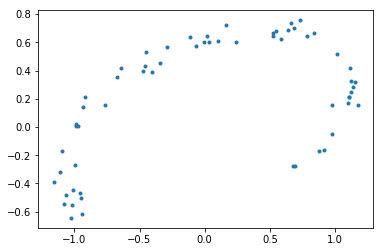

In [27]:
plt.plot(X[:, 0], X[:, 1], ".");

In [33]:
np.diag(s)

array([[6.77645005, 0.        , 0.        ],
       [0.        , 2.82403671, 0.        ],
       [0.        , 0.        , 0.78116597]])

In [36]:
m, n = X.shape
S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [37]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In Scikit-Learn:

In [38]:
from sklearn.decomposition import PCA

In [45]:
pca = PCA(n_components=2)
X2D_skl = pca.fit_transform(X)

In [46]:
X2D[:3]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729]])

In [47]:
X2D_skl[:3]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729]])

Components:

In [49]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

Explained variance ratio:

In [50]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

## MNIST compression

In [61]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [62]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

Choose the correct amount of dimensions:

In this case we need 95% of variance in our dataset after dimensionality reduction

In [63]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print("Dimension we need: ", d)

Dimension we need:  154


Or the same as above:

In [72]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

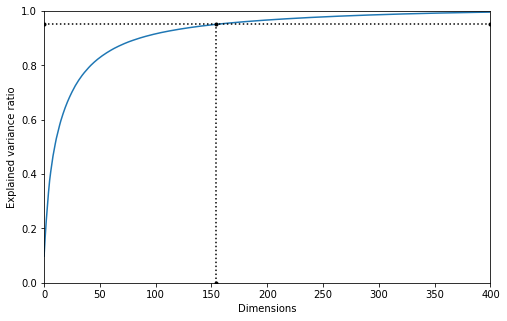

In [71]:
plt.figure(figsize=(8, 5))
plt.plot(cumsum)
plt.plot([d, d], [0, cumsum[d-1]], "k:.")
plt.plot([0, 400], [cumsum[d-1], cumsum[d-1]], "k:.")
plt.xlabel("Dimensions")
plt.ylabel("Explained variance ratio")
plt.axis([0, 400, 0, 1]);

In [77]:
np.random.seed(42)

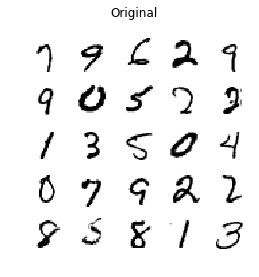

In [97]:
fig, axes = plt.subplots(5, 5, figsize=(4, 4))
fig.suptitle("Original")
indices = np.random.randint(0, len(X_train), 25)
digits = X_train[indices]
for digit, ax in zip(digits, axes.ravel()):
    ax.imshow(digit.reshape(28, 28), cmap=plt.cm.binary, interpolation="nearest")
    ax.axis("off")

Recovering:

$\mathbf{X}_{\text{recovered}} = \mathbf{X}_{d-\text{projectoion}}\cdot{\mathbf{W}_d}^T$

In [98]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

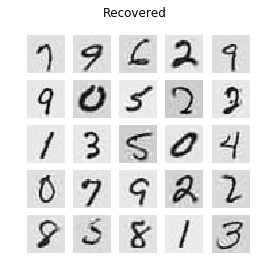

In [99]:
fig, axes = plt.subplots(5, 5, figsize=(4, 4))
fig.suptitle("Recovered")
digits = X_recovered[indices]
for digit, ax in zip(digits, axes.ravel()):
    ax.imshow(digit.reshape(28, 28), cmap=plt.cm.binary, interpolation="nearest")
    ax.axis("off")

## Incremental PCA - IPCA

In [100]:
from sklearn.decomposition import IncrementalPCA

In [101]:
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)   # NOT fit!
X_reduced = inc_pca.transform(X_train)
X_reduced.shape

(52500, 154)

Or it's possible to use ``memmap`` class to work with data on disk (not in memory):

In [103]:
filename = "../data/my_mnist.data"
m, n = X_train.shape
X_mm = np.memmap(filename, dtype="float32", mode="write", shape=(m, n))
X_mm[:] = X_train

In [104]:
del X_mm  # to be sure that the data is saved to disk

In [105]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))
batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

__Randomized PCA__

$O(m\times d^2) + O(d^3)$ inplace of $O(m\times n^2) + O(n^3)$

works faster if $d \ll n$ than other PCA algorythms

In [110]:
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)